## Setup

In [ ]:
# Install required python packagesspike_recorder_soma
# !pip install -r ../requirements.txt

## Imports

In [1]:
import sys
import os 
import warnings
import numpy as np

pkg_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(pkg_path)

np.set_printoptions(threshold=np.inf, suppress=True, linewidth=np.inf)
warnings.filterwarnings(action='ignore', category=UserWarning)

import shtmbss2.addsrc
from shtmbss2.common.config import *
from shtmbss2.core.logging import log

Could not load module 'colorlog'. Continuing logging without colored formatter.


In [2]:
RuntimeConfig.backend = Backends.BRAIN_SCALES_2
RuntimeConfig.plasticity_location = PlasticityLocation.OFF_CHIP

In [3]:
shtm = None
if RuntimeConfig.backend == Backends.BRAIN_SCALES_2:
    from pynn_brainscales import brainscales2 as pynn
    from shtmbss2.brainscales2.hardware import hardware_initialization
    from shtmbss2.brainscales2.network import SHTMTotal
    # TODO: remove once grenade supports dense inter-population-view projections
    neuronPermutation = []
    shtm = SHTMTotal(use_on_chip_plasticity=RuntimeConfig.plasticity_location == PlasticityLocation.ON_CHIP)
    alphabet_size = shtm.p.Network.num_symbols
    num_neurons_per_symbol = shtm.p.Network.num_neurons
    for a in range(alphabet_size):
        # dendrites
        for i in range(num_neurons_per_symbol):
            neuronPermutation.append((a * num_neurons_per_symbol + i) * 2)
    for a in range(alphabet_size):
        # somas
        for i in range(num_neurons_per_symbol):
            neuronPermutation.append((a * num_neurons_per_symbol + i) * 2 + 1)
    for i in range(alphabet_size * num_neurons_per_symbol * 2, 512):
        neuronPermutation.append(i)
        
    
    # print(neuronPermutation)

    hardware_initialization(neuronPermutation=neuronPermutation)
elif RuntimeConfig.backend == Backends.NEST:
    from shtmbss2.nest.network import SHTMTotal
    
from shtmbss2.common.network import NeuronType, RecTypes

INFO  10:02:34,450  demo_helpers Using setup hxcube7fpga0chip57_1


## Configuration

In [4]:
# pynn.logger.default_config(level=pynn.logger.LogLevel.DEBUG)
# log.handlers[LogHandler.STREAM].setLevel(logging.DEBUG)

debug = False

experiment_num = None

## Network Initialization

In [5]:
if shtm is None:
    shtm = SHTMTotal()

# FIXME: the timer only starts at start_time + period, fake calculation
# to get exactly one execution at the end of each runtime
if RuntimeConfig.plasticity_location == PlasticityLocation.ON_CHIP:
    shtm.init_plasticity_rule()
shtm.init_neurons()
shtm.init_connections(debug=debug)
shtm.init_external_input()

if RuntimeConfig.backend == Backends.BRAIN_SCALES_2:
    shtm.init_rec_exc()
    
shtm.experiment_num = experiment_num

Starting preprocessing/calibration...


In [7]:
if RuntimeConfig.plasticity_location == PlasticityLocation.ON_CHIP:
    pynn.preprocess()
    shtm.plasticity_rule.changed_since_last_run = True
    pynn.preprocess()

log.info("Calibration done!")

Calibration done!


In [6]:
#shtm = SHTMTotal.load_full_state(SHTMTotal, "test", 12)


## Network Emulation & Plotting

In [9]:
shtm.run(steps=100, plasticity_enabled=RuntimeConfig.plasticity_location==PlasticityLocation.OFF_CHIP)

Running emulation step 1/100
Computing performance for 2 Sequences.
Starting plasticity calculations
Running emulation step 2/100
Computing performance for 2 Sequences.
Starting plasticity calculations
Running emulation step 3/100
Computing performance for 2 Sequences.
Starting plasticity calculations
Running emulation step 4/100
Computing performance for 2 Sequences.
Starting plasticity calculations
Running emulation step 5/100
Computing performance for 2 Sequences.
Starting plasticity calculations
Running emulation step 6/100
Computing performance for 2 Sequences.
Starting plasticity calculations
Running emulation step 7/100
Computing performance for 2 Sequences.
Starting plasticity calculations
Running emulation step 8/100
Computing performance for 2 Sequences.
Starting plasticity calculations
Running emulation step 9/100
Computing performance for 2 Sequences.
Starting plasticity calculations
Running emulation step 10/100
Computing performance for 2 Sequences.
Starting plasticity ca

In [ ]:
%matplotlib inline
shtm.plot_data_overview()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

cor = np.array(shtm.exc_to_exc_soma_to_soma_dummy[0].get_data("correlation")[-1].data)
np.max(cor)

# plt.hist(cor)

data_arr = cor.reshape((60, 60))
data_arr[data_arr<115] = 0 

plt.imshow(data_arr, interpolation='nearest')


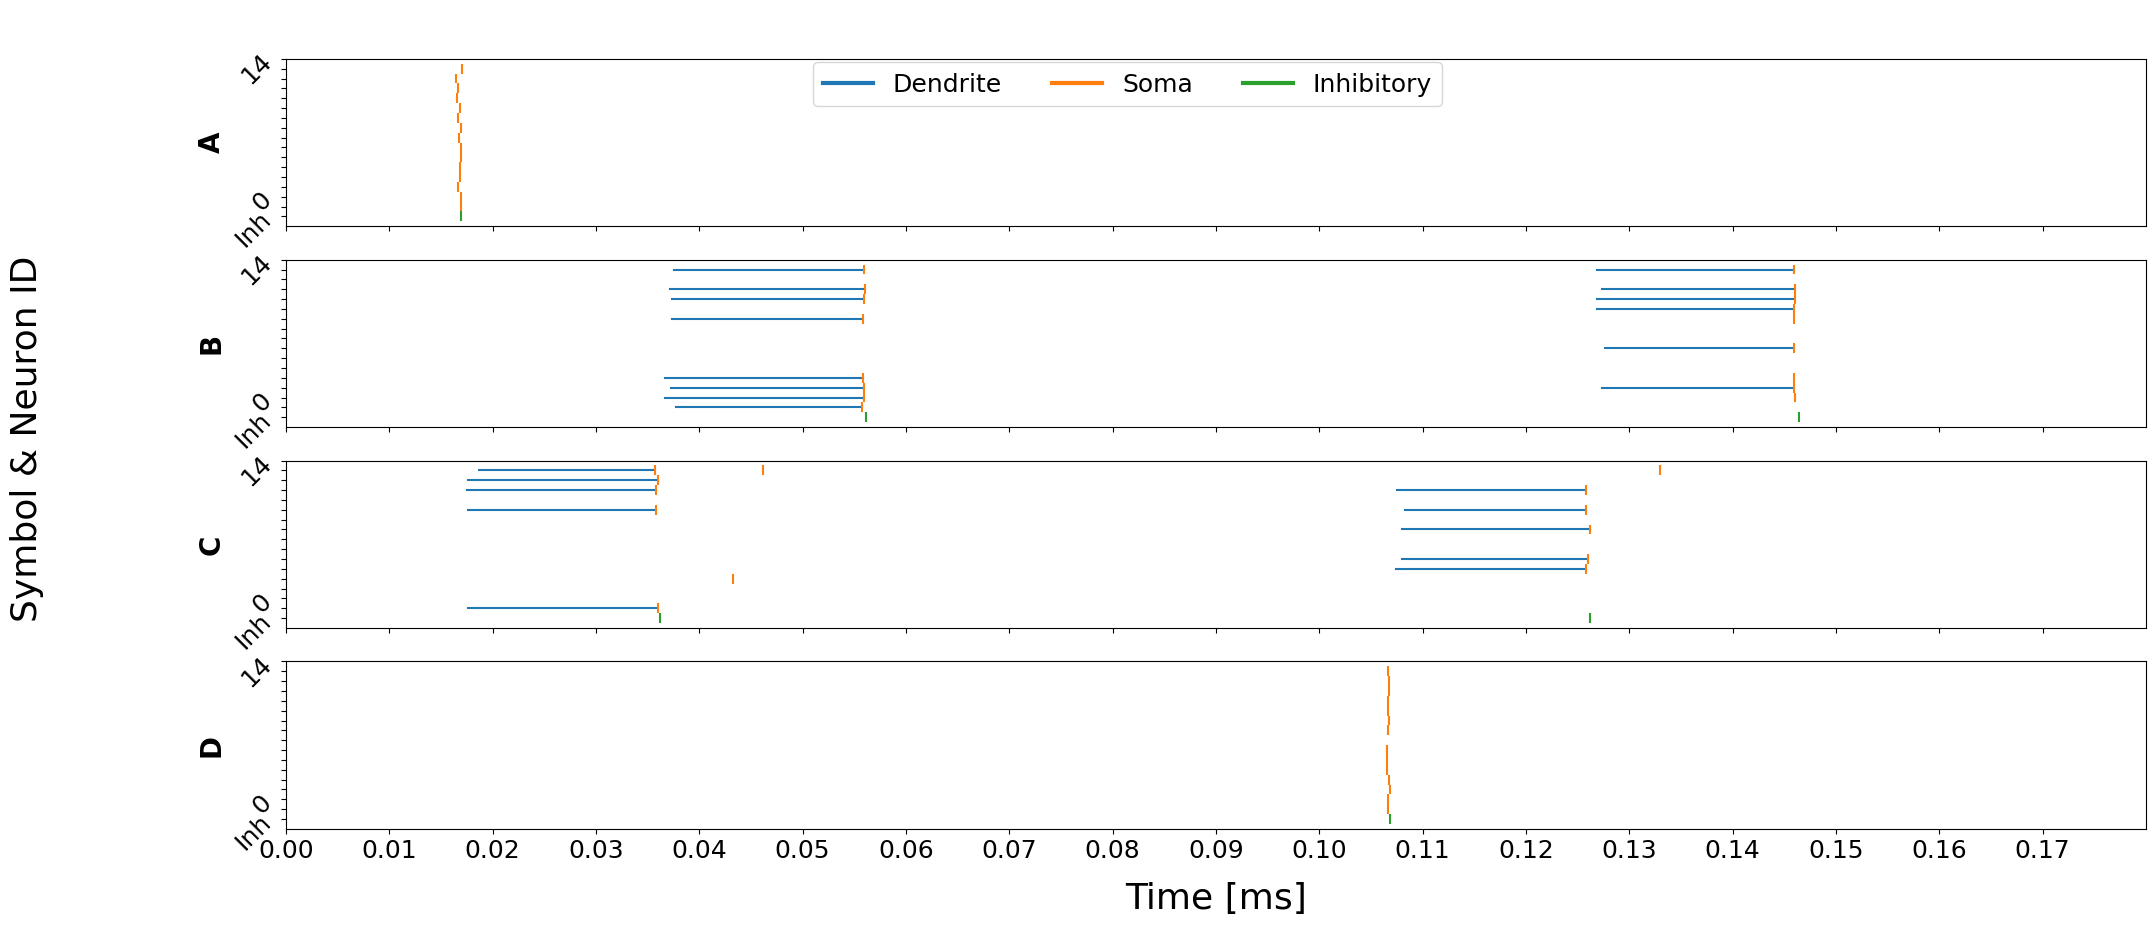

In [10]:
%matplotlib inline
shtm.plot_events(neuron_types="all", size=(24, 10))

In [ ]:
%matplotlib inline

run_length = shtm.p.Experiment.runtime / shtm.p.Encoding.num_repetitions
perf_run = np.ceil(shtm.p.Plasticity.execution_start / run_length) - 1

run = perf_run


shtm.plot_events(neuron_types="all", size=(24, 10), 
            window="final", 
            x_lim_lower=run*(shtm.p.Experiment.runtime / 200), x_lim_upper=(run+1)*(shtm.p.Experiment.runtime / 200)
           )

## Plot performance

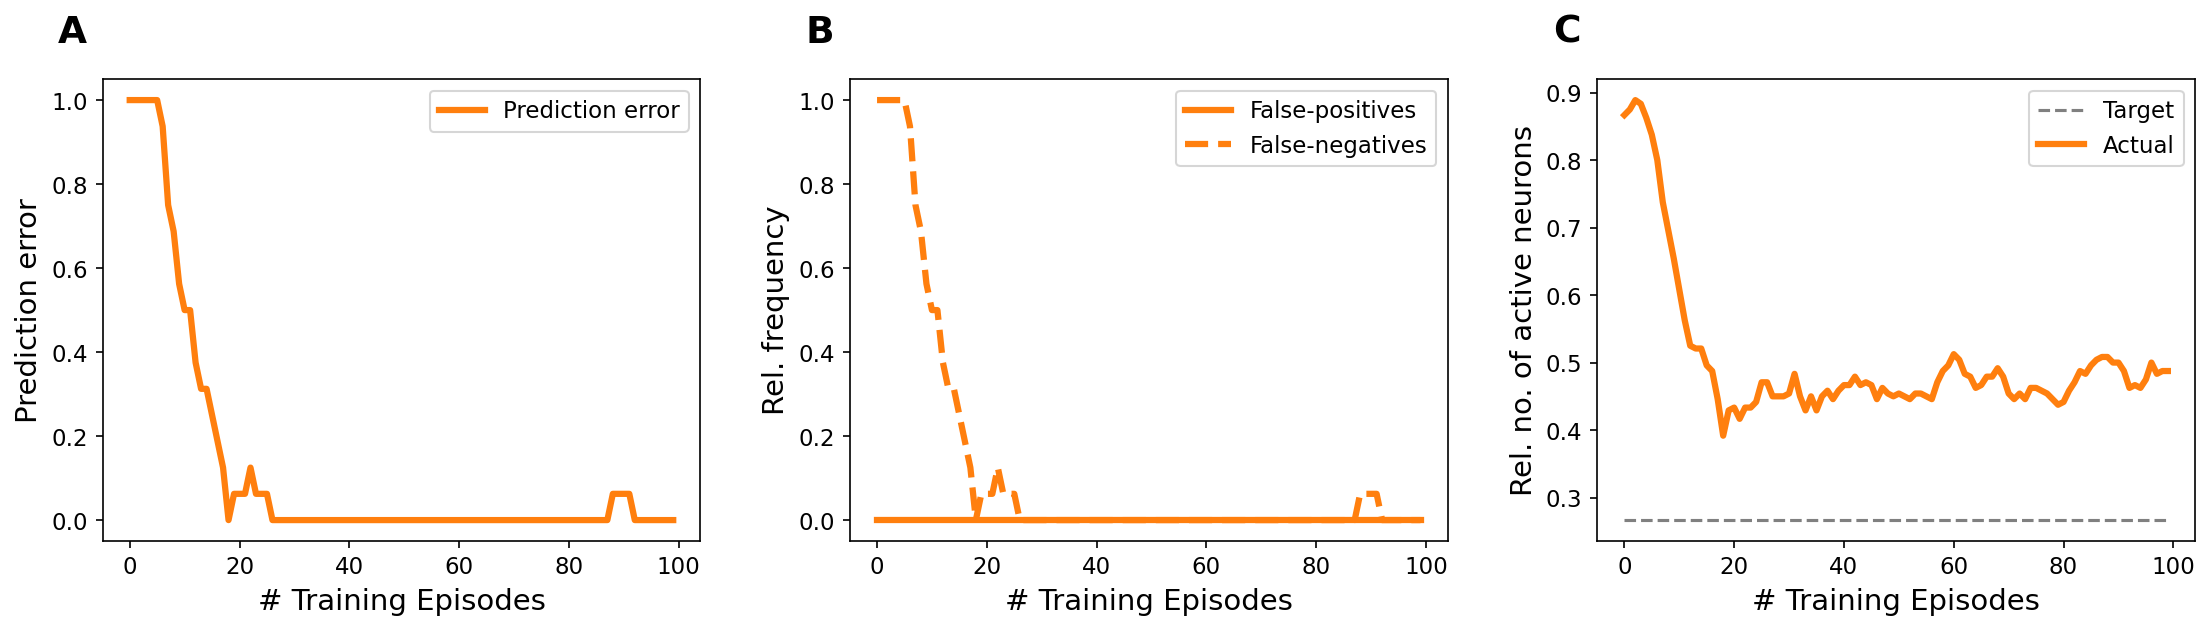

In [11]:
%matplotlib inline

shtm.plot_performance(StatisticalMetrics.MEAN)

In [ ]:
%matplotlib inline

shtm.plot_permanence_history(plot_con_ids="all")

In [ ]:
# shtm.con_plastic[0].permanences[0]
shtm.exc_to_exc[0].get("weight", format="array")

In [ ]:
# shtm.save_full_state()

## Dendrite wrong spike analysis

In [17]:
spikes_soma = shtm.neuron_events[NeuronType.Soma][3]
spikes_soma[1]

array([  0.656856,   1.936848,   3.216776,   4.496816,   5.776792,   7.056848,   8.33684 ,   9.616816,  10.896816,  12.17684 ,  13.456784,  14.736832,  16.01688 ,  17.29684 ,  18.576848,  19.856944,  21.13692 ,  22.41684 ,  23.69684 ,  24.976824,  26.256808,  27.536864,  28.816752,  30.096856,  31.37684 ,  32.656824,  33.936872,  35.216792,  36.496912,  37.776832,  39.056808,  40.33688 ,  41.616864,  42.896904,  44.17684 ,  45.456848,  46.736848,  48.016792,  49.296848,  50.576856,  51.856816,  53.136784,  54.416736,  55.6968  ,  56.976792,  58.256808,  59.536912,  60.8168  ,  62.09684 ,  63.376832,  64.656816,  65.93676 ,  68.496792,  70.16596 ,  71.056832,  73.61684 ,  75.212264,  76.176816,  77.694368,  81.296768,  82.72528 ,  91.978152,  92.816848,  95.376808,  97.936888, 100.496872, 103.056872, 108.764608, 111.239552, 113.811936, 116.294056, 119.696792, 122.256728, 123.81324 , 124.81688 , 126.285232, 132.919712, 135.305632, 136.838592, 140.182976, 141.855136, 142.736832, 145.2968 

In [13]:
spikes_dend = shtm.neuron_events[NeuronType.Dendrite][2]
spikes_dend[0]

array([ 46.757904,  47.398008,  51.238048,  52.518096,  53.797992,  54.43736 ,  55.077296,  55.717392,  56.997128,  57.63788 ,  58.277296,  58.91784 ,  60.837896,  61.477824,  62.117552,  62.757912,  67.877816,  72.997304,  76.250584,  83.238032,  85.797856,  93.477872,  98.597424, 101.141528, 101.157968, 103.717376, 105.637728, 106.277864, 110.757904, 115.877904, 118.43776 , 120.997576, 123.557736, 126.117896, 128.67728 , 131.237768, 133.797744, 136.35712 , 141.477536, 143.397856, 144.037552, 146.597504, 149.157872, 153.637744, 156.198048, 158.757376, 161.317248, 163.877888, 168.997792, 171.557344, 176.6628  , 176.677904, 181.157792, 186.27776 , 191.39776 , 193.957728, 196.517792, 201.637376, 204.197824, 211.87792 , 214.437936, 219.557344, 222.118016, 224.677856, 229.157856, 232.357568, 234.27792 , 236.83712 , 239.397056, 241.957472, 244.51792 , 249.637152, 252.19744 , 254.757344]) * ms

In [ ]:
shtm.con_plastic[9].x[-1].reshape(15, 15)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

spikes = np.array(shtm.exc_to_exc_soma_to_soma_dummy[0].get_data("correlation")[-1].data)
spikes = spikes.reshape((60, 60))

# spike_sum = np.sum(spikes, axis=0)
spike_sum = np.max(spikes, axis=0)

plt.plot(spike_sum)

In [14]:
permanences = np.array(shtm.exc_to_exc_dendrite_to_soma_dummy[0].get_data("data")[-1].data).flatten()
permanences = permanences.reshape((60, 60))


In [20]:
shtm.con_plastic[0].permanences[-1]

array([   5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,    5, -118,    5, -118,    5, -128,    5, -128,    5, -118,    5, -120,    5, -119,    5,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,  -81,    5, -128,    5,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5, -128,    5,    

In [11]:
symbol_id=3
neuron_id=1
neuron_type=NeuronType.Dendrite
# runtime=shtm.p.Experiment.runtime / shtm.p.Encoding.num_repetitions * 10 + shtm.p.Encoding.t_exc_start  
runtime=shtm.p.Experiment.runtime
show_legend=False

shtm.reset()

shtm.reset_rec_exc()
shtm.init_rec_exc(alphabet_id=symbol_id, neuron_id=neuron_id, neuron_type=neuron_type)
shtm.run_sim(runtime)

data = shtm.rec_neurons_exc.get_data("v").segments[-1].irregularlysampledsignals

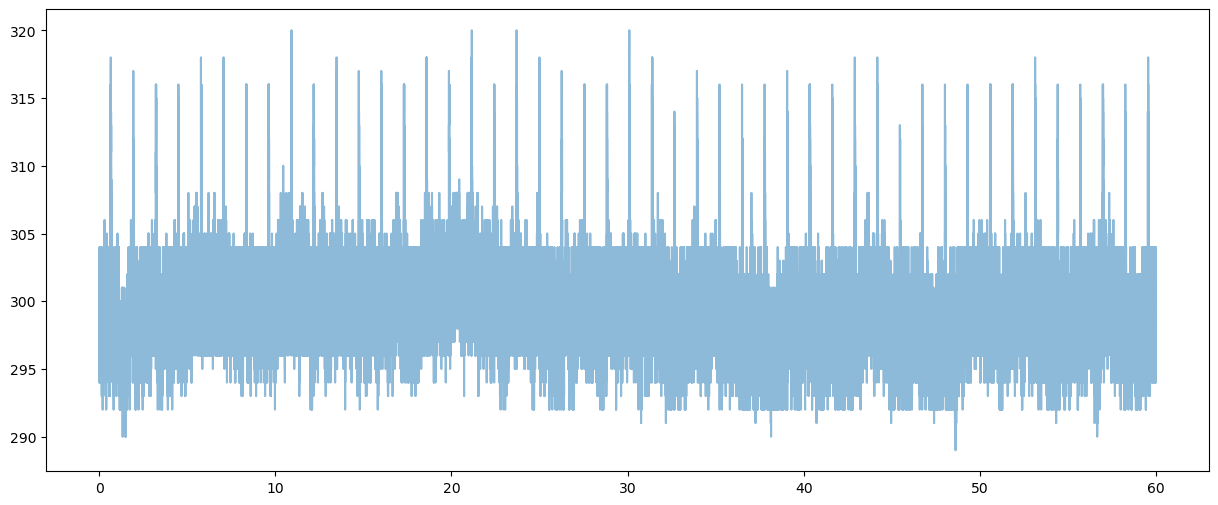

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

run = 39

x_lim_lower=run*(shtm.p.Experiment.runtime / shtm.p.Encoding.num_repetitions)
x_lim_upper=(run+1)*(shtm.p.Experiment.runtime / shtm.p.Encoding.num_repetitions)

x_lim_lower = 0
x_lim_upper = 60

lim_low = np.argmax(data[0].times > x_lim_lower)
lim_up = np.argmax(data[0].times > x_lim_upper)

# lim_up = len(data[0].times)

plt.figure(figsize=(15,6))
plt.plot(data[0].times[lim_low:lim_up], data[0][lim_low:lim_up], alpha=0.5)

In [ ]:
# spike-time ext: 54.415
# spike-time soma: 54.416736
# spike-time dend: 54.417568

In [16]:
spikes_dend = shtm.get_neuron_data(NeuronType.Dendrite, symbol_id=3, neuron_id=1, dtype=np.ndarray)
print(spikes_dend[:, 1])

[  0.017744   1.297768   2.5786     5.138648   7.6978    11.53852   12.817736  14.098552  15.3786    17.938624  19.218464  20.49776   21.778536  23.058488  25.617768  26.8986    28.177792  30.738544  32.018568  33.297728  34.577728  35.85776   37.138544  38.418552  39.69776   42.258888  43.537728  44.178432  44.818712  45.45848   46.097712  47.37776   48.017648  48.657784  51.858824  54.417568  58.25844   60.818464  62.098424  65.938424  77.458504  85.138504  96.658488 100.49856  104.338584 119.697504 123.538568 131.21752  160.658496 187.53856  191.37856  206.738688 218.258656 225.938656 233.618576 237.4584   241.298624 245.138464 252.818496]


In [14]:
shtm.p.Encoding.t_exc_start + runtime/200*42 + shtm.p.Encoding.dt_stm * 2 + shtm.p.Encoding.dt_seq

54.41499999999945

248.00000000000014 49.60000000000002 50.840000000000025


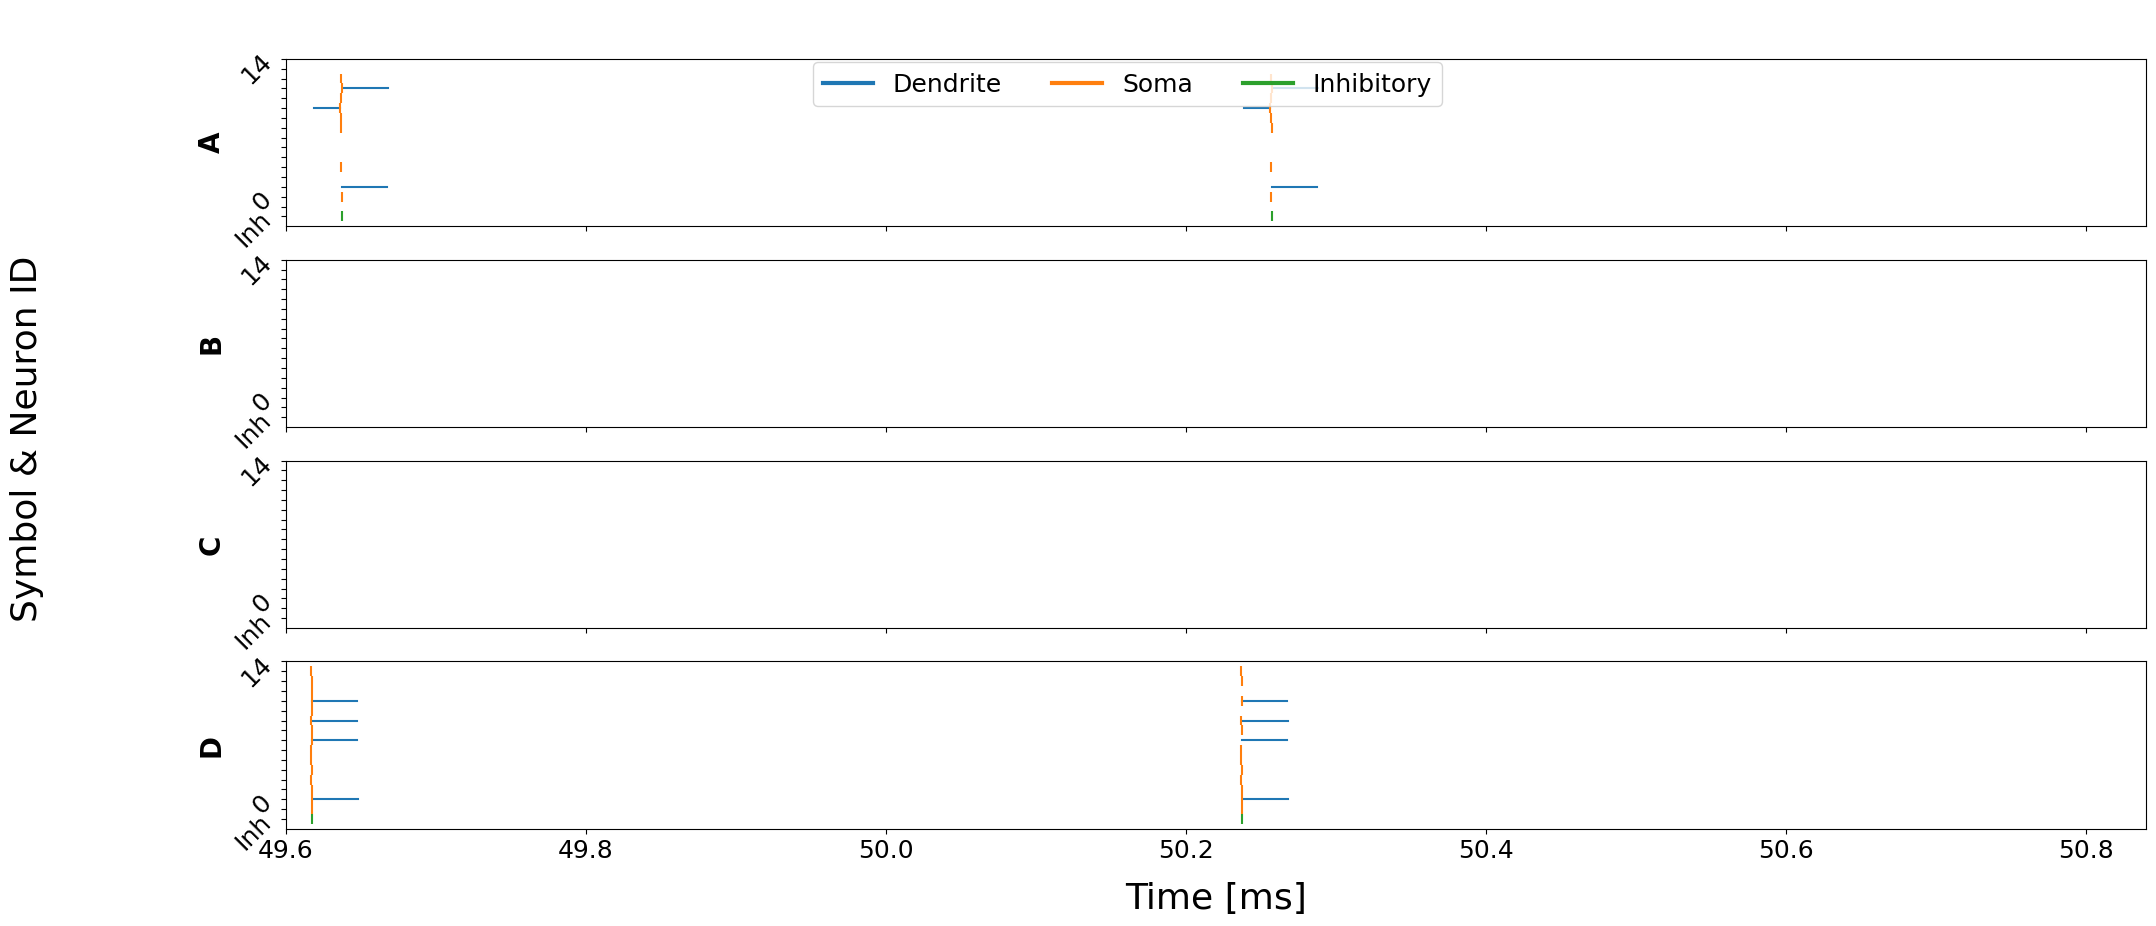

In [57]:
%matplotlib inline

run = 40

plot_events(shtm, neuron_types="all", size=(24, 10), 
            window="final", 
            x_lim_lower=run*(shtm.p.Experiment.runtime / 200), x_lim_upper=(run+1)*(shtm.p.Experiment.runtime / 200)
           )

## Second run

In [ ]:
shtm.run(steps=10, plasticity_enabled=True)

In [ ]:
%matplotlib inline

shtm.plot_events(neuron_types="all", size=(24, 10))

In [ ]:
%matplotlib inline

shtm.plot_performance()

In [ ]:
shtm.run(steps=10, plasticity_enabled=True)

In [ ]:
%matplotlib inline

shtm.plot_events(neuron_types="all", size=(24, 10))

In [ ]:
shtm.set_weights_exc_exc(10, 1, post_ids=[3,4,5], p_con=1.0)
shtm.run(steps=1, plasticity_enabled=True)

# %matplotlib inline
# shtm.plot_events(neuron_types="all", size=(24, 10))

## Additional Plotting

In [ ]:
%matplotlib inline

shtm.plot_permanence_diff()

In [ ]:
%matplotlib inline

# for i in [0, 1]:
#     print(shtm.con_plastic[i].permanences)

shtm.plot_permanence_history(plot_con_ids=[0, 1, 7])

In [ ]:
%matplotlib inline
from shtmbss2.common.network import NeuronType, RecTypes

shtm.plot_v_exc(alphabet_range=[2], neuron_range="all", neuron_type=NeuronType.Soma)

In [ ]:
%matplotlib inline

shtm.plot_v_exc(alphabet_range=[0], neuron_range='all', neuron_type=NeuronType.Dendrite, runtime=runtime, show_legend=False)

In [ ]:
%matplotlib inline

shtm.plot_v_exc(alphabet_range=range(1, alphabet_size))

## Additional Analysis

In [ ]:
for i in range(len(shtm.con_plastic)):
    shtm.con_plastic[i].mature_weight = 120
    print(i, shtm.con_plastic[i].projection.label.split('_')[1], shtm.con_plastic[i].get_all_connection_ids())
    

In [ ]:
arr = np.array(shtm.con_plastic[1].permanences)

In [ ]:
for c in shtm.con_plastic[1].projection.connections:
    print(f'C[{c.presynaptic_index}, {c.postsynaptic_index}].weight = {c.weight}')

In [ ]:
np.set_printoptions(threshold=np.inf, suppress=True, linewidth=np.inf)
shtm.con_plastic[1].projection.get("weight", format="array")

In [ ]:
shtm.con_plastic[7].projection.get("weight", format="array")

In [ ]:
# Print spikes form spiketrain
for s in shtm.con_plastic[1].projection.post.get_data("spikes").segments[-1].spiketrains:
    print(s)
print(len(shtm.con_plastic[1].projection.post.get_data("spikes").segments[-1].spiketrains))
print(len(shtm.con_plastic[1].projection.connections))

In [ ]:
for con in shtm.con_plastic:
    print(f"Sum(P[{con.projection.label}]) = {np.sum(con.permanences[-1] - con.permanences[0])}")

In [ ]:
dendrites, somas = shtm.get_spike_times(0.44, 0.1e-2)

print(somas)

In [ ]:
for i_plastic in range(len(shtm.con_plastic)):
    shtm.con_plastic[i_plastic].lambda_plus *= 2
    shtm.con_plastic[i_plastic].lambda_minus *= 2
    shtm.con_plastic[i_plastic].lambda_h *= 2
    
    # print(f"Sum(P[{con.projection.label}]) = {np.sum(con.permanences[-1] - con.permanences[0])}")

## Check indices

In [ ]:
dendrites, somas = shtm.neurons_exc[0]

print(somas.all_cells)
print(somas.id_to_index(13))

print(somas.get_data("spikes").segments[-1].spiketrains[8])
print(shtm.con_plastic[0].projection.pre.get_data("spikes").segments[-1].spiketrains[8])

## Check spikes

In [ ]:
dendrites, somas = shtm.neurons_exc[0]

spike_ids_a = list()
spike_ids_b = list()

# Print spikes form spiketrain
for s in somas.get_data("spikes").segments[-1].spiketrains:
    print(s)
    if len(s) > 0:
        print(s[0]/0.1e-3)
        spike_ids_a.append(int(s[0]/0.1e3))

    # for t in np.linspace(0., runtime, int(runtime / 0.1e-3)):
        
    
print(len(somas.get_data("spikes").segments[-1].spiketrains))



In [ ]:
print(shtm.neurons_exc[0][0].get("tau_m"))
print(shtm.neurons_inh[0].tau_m)
w = shtm.exc_to_inh[1].get("weight", format="array")
print(w)
print(pynn.get_current_time())

## Save objects

In [ ]:
import pickle

experiment_name = "shtm_off-chip_01"

with open(f'../evaluation/objects/{experiment_name}.pkl', 'wb') as out_file:
    pickle.dump(shtm, out_file)

In [ ]:
with open(f'../evaluation/objects/{experiment_name}.pkl', 'rb') as in_file:
    obj = pickle.load(in_file)

## Plotting - Events - All Symbols

In [ ]:
%matplotlib inline

seq = 2

fig_title = "Neuronal Events for Sequence {D, C, B} - After Learning"

file_path = f"../evaluation/figures/shtm-bss2_eval_learning-off-chip_seq-0{seq}_before-learning"
# file_path = f"../evaluation/figures/shtm-bss2_eval_learning-off-chip_seq-0{seq}_after-learning"

# file_path += "_a"

if seq == 1:
    fig = shtm.plot_events(shtm, size=[12, 10], x_lim_lower=0, x_lim_upper=0.14, seq_start=0.0, seq_end=0.14, fig_title=fig_title, file_path=file_path)
elif seq == 2:
    fig = shtm.plot_events(shtm, size=[12, 10], x_lim_lower=0.22, x_lim_upper=0.36, seq_start=0.22, seq_end=0.36, fig_title=fig_title, file_path=file_path)
    


## Plotting - Events - One Symbol

In [ ]:
%matplotlib inline

fig_title = "Neuronal Events for Sequence {D, C, B} - After Learning"
file_path = f"../evaluation/figures/shtm-bss2_eval_limits-spikes_w-inh"

# file_path += "_a"

fig = shtm.plot_events(shtm, neuron_types="all", symbols=[2], size=[12, 10], x_lim_lower=0, x_lim_upper=0.14, seq_start=0.0, seq_end=0.14, fig_title=fig_title, file_path=file_path)


spikes = shtm.neurons_exc[2][1].get_data("spikes").segments[-1].spiketrains

In [ ]:
# file_path_open = f"../evaluation/figures/shtm-bss2_eval_limits-volts_w-inh"
# file_path_open = f"../evaluation/figures/shtm-bss2_eval_limits-volts_wo-inh"
# file_path_open = f"../evaluation/figures/shtm-bss2_eval_limits-spikes_w-inh"
file_path_open = f"../evaluation/figures/shtm-bss2_eval_limits-spikes_wo-inh"

figx = pickle.load(open(f'{file_path_open}.fig.pickle', 'rb'))
figx.set_size_inches(12, 6)

figx.legends = []
figx.suptitle("")
figx.subplots_adjust(top=0.85)
neuron_types = [NeuronType.Dendrite, NeuronType.Soma, NeuronType.Inhibitory]
custom_lines = [Line2D([0], [0], color=f"C{n.ID}", label=n.NAME.capitalize(), lw=3) for n in neuron_types]
plt.figlegend(handles=custom_lines, loc=(0.402, 0.888), ncol=3, labelspacing=0., fontsize=18, fancybox=True, borderaxespad=1)


# figx.show()

figx.savefig(f"{file_path_open}.pdf", bbox_inches='tight')
# figx.savefig(f"{file_path_open}.png")

## Final Plots - Voltage

In [ ]:
%matplotlib inline

# plt.rcParams.update({'font.size': 12})

seq = 2

# file_path = f"../evaluation/figures/shtm-bss2_eval_learning-off-chip_seq-0{seq}_before-learning"
# file_path = f"../evaluation/figures/shtm-bss2_eval_learning-off-chip_seq-0{seq}_after-learning"
file_path = f"../evaluation/figures/shtm-bss2_eval_limits-volts_w-inh"

# file_path += "_a"

# if seq == 1:
    # fig = plot_v_exc(shtm, [0], neuron_range="all", size=[12, 10], x_lim_lower=0, x_lim_upper=0.14, seq_start=0.0, seq_end=0.14, file_path=file_path)
# elif seq == 2:
    # fig = plot_v_exc(shtm, [0], neuron_range="all", size=[12, 10], x_lim_lower=0.22, x_lim_upper=0.36, seq_start=0.22, seq_end=0.36, file_path=file_path)

shtm.plot_v_exc(shtm, [2], neuron_range="all", size=[12, 10], runtime=0.14, file_path=file_path)

    
